# 1. DeepLab 을 이용하기 위한 준비

### 1-1.이미 학습이 끝난 모델 파일을 다운로드 한다

In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt
# 저장할 파일 이름을 결정합니다
# 1. os.getenv(x)함수는 환경 변수x의 값을 포함하는 문자열 변수를 반환합니다. model_dir 에 "/aiffel/human_segmentation/models" 저장
# 2. #os.path.join(a, b)는 경로를 병합하여 새 경로 생성 model_file 에 "/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5" 저장
# 1

model_dir = './' 
# 2
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file) # urllib 패키지 내에 있는 request 모듈의 urlretrieve 함수를 이용해서 model_url에 있는 파일을 다운로드 해서 model_file 파일명으로 저장

('./deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f751275ee80>)

### 1-2.다운로드한 모델 파일을 적용한다.

In [2]:
model = semantic_segmentation() #PixelLib 라이브러리 에서 가져온 클래스를 가져와서 semantic segmentation을 수행하는 클래스 인스턴스를 만듬
model.load_pascalvoc_model(model_file) # pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출

### 1-3.테스트 하고자 하는 이미지를 불러온다

In [3]:
def draw_image(img_path):
    img_read = cv2.imread(img_path) 
    print(img_read.shape)
    plt.imshow(cv2.cvtColor(img_read, cv2.COLOR_BGR2RGB))
    plt.show()
    return img_read # BGR image

(474, 710, 3)


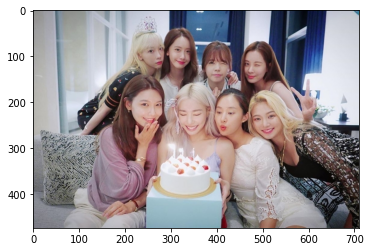

(294, 500, 3)


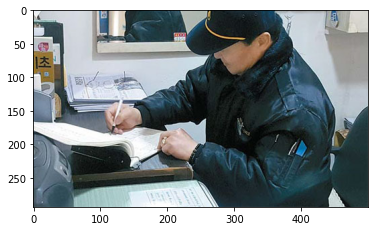

(223, 226, 3)


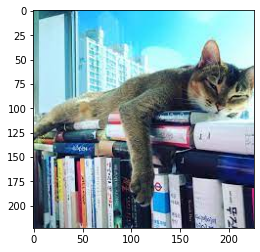

(438, 700, 3)


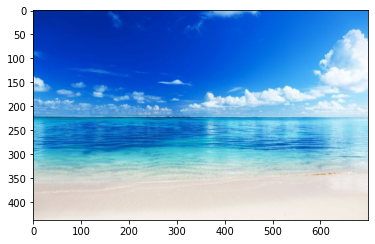

In [4]:
girls_img = draw_image('./images/girls.jpg')
man_img = draw_image('./images/man.jpg')
cat_img = draw_image('./images/cat.jpg')
bg_sea_img = draw_image('./images/bg_sea.jpg')

### 1-4. 테스트에 필요한 함수 모음

In [5]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
# 분할된 클래스 id와 이름정보를 출력 하는 함수
def print_segvalue(segvalues):
    global LABEL_NAMES
    for class_id in segvalues['class_ids']:
        print('class_id=',class_id,'names=',LABEL_NAMES[class_id])

# 분할된 영역을 화면에 표시하는 함수        
def draw_segment(model,image_path):
# segmentAsPascalvoc()함 수 를 호출 하여 입력된 이미지를 분할, 
# 분할 출력의 배열을 가져옴, 분할 은 pacalvoc 데이터로 학습된 모델을 이용
    segvalues, output = model.segmentAsPascalvoc(image_path)
    plt.imshow(output)
    plt.show()
    return segvalues,output

# 분할된 영역 중에서 특정 색상과 일치하는 영역만 화면에 표시 하는 함수
def draw_seg_mask_by_color(seg_out,seg_color):
    seg_mask = np.all(seg_out==seg_color, axis=-1) 
    print(seg_mask.shape) 
    plt.imshow(seg_mask, cmap='gray')
    plt.show()
    # True과 False인 값을 각각 255과 0으로 바꿔줍니다
    mask_rgb = seg_mask.astype(np.uint8)*255
    return cv2.cvtColor(mask_rgb, cv2.COLOR_GRAY2BGR)

# fg_img에서 fg_mask를 제외한 나머지 영역을 blur 처리시키는 함수
def bluring_bg_image(fg_img,fg_mask):
    bg_img = fg_img.copy()
    blur_bg_img = cv2.blur(bg_img, (13,13)) # blurring kernel size 13x13
    bg_mask = cv2.bitwise_not(fg_mask)
    blur_bg_img = cv2.bitwise_and(blur_bg_img, bg_mask)
    img_concat = np.where(fg_mask==255,fg_img,blur_bg_img)
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()

# fg_img에서 fg_mask를 제외한 나머지 영역을 bg_img로 대체시키는 함수
def chroma_key_bg_image(fg_img,fg_mask,bg_img):
    resized_bg_img = cv2.resize(bg_img,(fg_img.shape[1],fg_img.shape[0]))
    bg_mask = cv2.bitwise_not(fg_mask)
    masked_bg_img = cv2.bitwise_and(resized_bg_img, bg_mask)
    img_concat = np.where(fg_mask==255,fg_img,masked_bg_img)
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()

In [6]:
# PixelLib에서 분할출력 되었을때 사용되는 컬러맵 정보
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] #생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

# 2. 인물모드 테스트(1)
### 2-1. 사진을 분할 시킨 결과

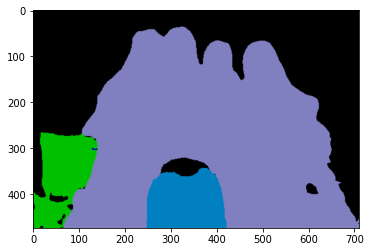

class_id= 0 names= background
class_id= 9 names= chair
class_id= 11 names= diningtable
class_id= 15 names= person
class_id= 18 names= sofa


In [7]:
girls_seg,girls_seg_out=draw_segment(model,'./images/girls.jpg')
print_segvalue(girls_seg)

### 2-2. class_id=15, names=person 색상 영역만 남기고 나머지 제거

In [8]:
colormap[15] # RGB person color

array([192, 128, 128])

(474, 710)


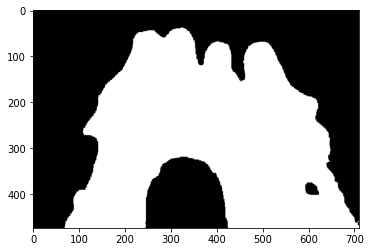

In [9]:
girls_fg_mask=draw_seg_mask_by_color(girls_seg_out,seg_color=(128,128,192)) # BGR persion color

### 2-3. 인물 영역 제외한 부분 blur처리

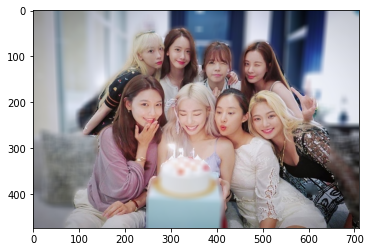

In [10]:
bluring_bg_image(girls_img,girls_fg_mask)

### 2-4. 인물영역 제외한 부분을 다른 이미지로 변경

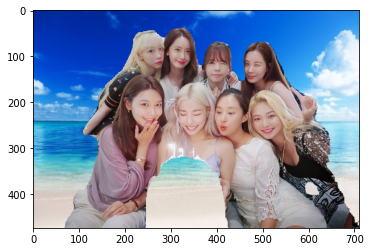

In [11]:
chroma_key_bg_image(girls_img,girls_fg_mask,bg_sea_img)

# 3. 인물모드 테스트(2)
### 3-1. 사진을 분할 시킨 결과

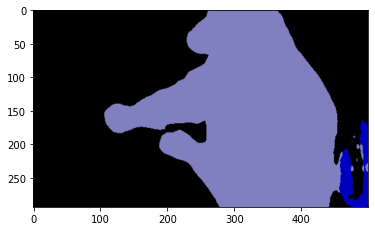

class_id= 0 names= background
class_id= 9 names= chair
class_id= 15 names= person


In [12]:
man_seg,man_seg_out=draw_segment(model,'./images/man.jpg')
print_segvalue(man_seg)

### 3-2. class_id=15, names=person 색상 영역만 남기고 나머지 제거

In [13]:
colormap[15]

array([192, 128, 128])

(294, 500)


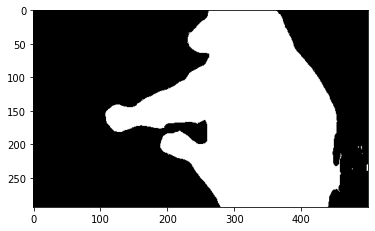

In [14]:
man_fg_mask=draw_seg_mask_by_color(man_seg_out,seg_color=(128,128,192)) # BGR persion color

### 3-3. 인물 영역 제외한 부분 blur처리

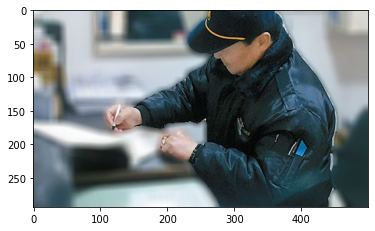

In [15]:
bluring_bg_image(man_img,man_fg_mask)

### 3-4. 인물영역 제외한 부분을 다른 이미지로 변경

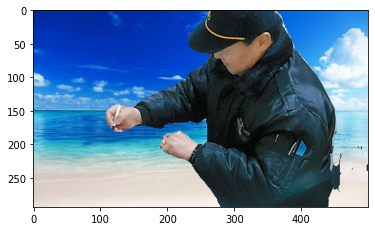

In [16]:
chroma_key_bg_image(man_img,man_fg_mask,bg_sea_img)

# 4. 동물모드 테스트
### 4-1. 사진을 분할 시킨 결과

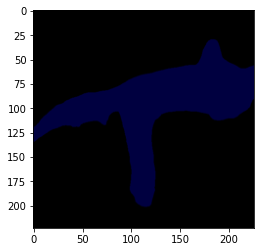

class_id= 0 names= background
class_id= 8 names= cat


In [17]:
cat_seg,cat_seg_out=draw_segment(model,'./images/cat.jpg')
print_segvalue(cat_seg)

### 4-2. class_id=8, names=cat 색상 영역만 남기고 나머지 제거

In [18]:
colormap[8]

array([64,  0,  0])

(223, 226)


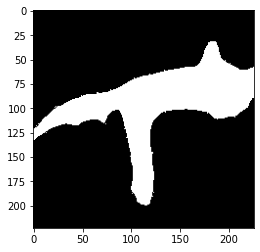

In [19]:
cat_fg_mask=draw_seg_mask_by_color(cat_seg_out,seg_color=(0,0,64)) # BGR cat color

### 4-3. 동물 영역 제외한 부분 blur처리

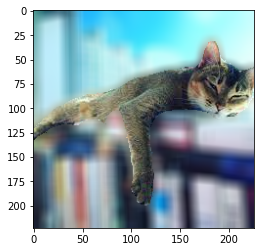

In [20]:
bluring_bg_image(cat_img,cat_fg_mask)

### 4-4. 동물영역 제외한 부분을 다른 이미지로 변경

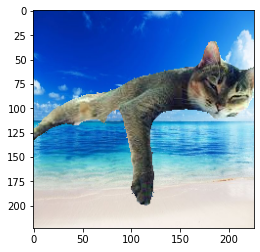

In [21]:
chroma_key_bg_image(cat_img,cat_fg_mask,bg_sea_img)

# 5.사진에서 문제점 찾기

(278, 537, 3)


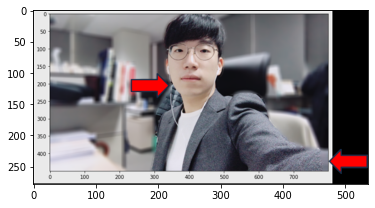

In [22]:
_=draw_image('./images/problem0.png')

1) 이어폰 선을 인물 영역으로 인식하지 못한 부분<br>
2) 소매 부분을 인물 영역으로 인식하지 못한 부분<br>

(341, 540, 3)


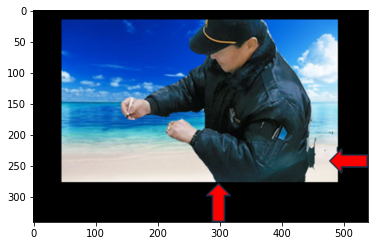

In [23]:
_=draw_image('./images/problem1.png')

3)팔꿈치 부분을 책상과 명확히 구분해 내지 못한 부분<br>
4)허리와 등 부분을 의자와 명확히 구분해 내지 못한 부분<br>

# 6.해결 방법 제안

### 6.1 DeepLab 라이브러리 + 인물자세인식및 옷 두께추정 기능 개발
- CNN사용하여 2차원 입력 이미지에 대하여 골격 좌표정보를 정답으로 학습 합니다.<br>
- DeepLab image segmentation 수행 후 골격 구조 좌표정보를 이용하여 적당한 옷 두께<br>
  까지만 mask를 적용하여 mask가 적용된 위치까지만 그려지도록 하는 기능 개발<br>
- 3)문제점: 팔의 두께가 골격 구조에 맞추어 일정하게 표시되도록 수정 가능<br>
- 4)문제점: 의자에 앉은 행동에 맞는 골격 구조에 맞추어 등 부분에서 일정한 간격 이상만 masking되므로 나머지 부분은 사라짐<br>

### 6.2 DeepLab 라이브러리 + 인물과 관련된 부착물 segmentation 기능 개발
- DeepLab 에서 segmentation 수행하는 것 처럼 인물과 관련된 악세사리, 옷, 모자, 안경, 신발 <br>
  등등 을 분리해내는 모델을 개발해서 2중으로 segmentation 시키면<br>
  1)번문제점: 이어폰 형태 학습이 되었기 때문에 이어폰 줄 부분이 정상적으로 표시될것 같습니다.<br>
  2)번문제점: 옷으로 인식되므로 소매부분이 짤리지 않게 할 수 있습니다.<br>